In [125]:
import math
import numpy as np
import pickle

import time
import glob
import numpy as np
import os
from PIL import Image, ImageDraw
# from scipy.misc import toimage
import matplotlib.pyplot as plt

from progress.bar import Bar
import multiprocessing



# Utility Functions

In [126]:
def buildFeatures(imgWidth, imgHeight, shift = 1, scale_factor = 1, minWidth = 4, minHeight = 4):

    features = []
    for w in range(minWidth, imgWidth + 1):
        for h in range(minHeight, imgHeight + 1):
            x = 0
            while x + w < imgWidth:
                y = 0
                while y + h < imgHeight:
                    # Possible Haar regions
                    immediate = Rectangle(x, y, w, h)
                    right = Rectangle(x + w, y, w, h)
                    right_2 = Rectangle(x + 2 * w, y, w, h)
                    bottom = Rectangle(x, y + h, w, h)
                    bottomRight = Rectangle(x + w, y + h, w, h)

                    # Haar 2 rectangles
                    if x + 2 * w < imgWidth:
                        features.append(HaarFeature([immediate], [right]))
                    if y + 2 * h < imgHeight:
                        features.append(HaarFeature([bottom], [immediate]))

                    # Haar 3 rectangles
                    if x + 3 * w < imgWidth:
                        features.append(HaarFeature([immediate, right_2], [right]))
                    
                    # Haar 4 rectangles
                    if x + 2 * w < imgWidth and y + 2 * h < imgHeight:
                        features.append(HaarFeature([immediate,bottomRight], [bottom, right]))
                    
                    y += shift
                x += shift
    return features

def unisonShuffledCopies(a, b):
    p = np.random.permutation(len(a))
    return a[p], b[p]

def evaluate(clf, X, y):
    metrics = {}
    truePos, trueNeg, falsePos, falseNeg = 0, 0, 0, 0
    
    for i in range(len(y)):
        prediction = clf.classify(X[i])
        truePos += (prediction * y[i])
        falsePos += (prediction* (1-y[i]))
        falseNeg += ((1-prediction) * y[i])
        trueNeg += ((1-prediction)*(1-y[i]))
        # if prediction == 1 and y[i] == 1:
        #     truePos += 1
        # elif prediction == 1 and y[i] == 0:
        #     falsePos += 1
        # elif prediction == 0 and y[i] == 1:
        #     falseNeg += 1
        # else:
        #     trueNeg += 1

    metrics['truePos'] = truePos
    metrics['trueNeg'] = trueNeg
    metrics['falsePos'] = falsePos
    metrics['falseNeg'] = falseNeg
    
    metrics['accuracy'] = (truePos + trueNeg) / (len(y))
    metrics['precision'] = truePos / (truePos + falsePos)
    metrics['recall'] = truePos / (truePos + falseNeg)
    metrics['f1'] = 2 * metrics['precision'] * metrics['recall'] / (metrics['precision'] + metrics['recall'])
    metrics['specificity'] = trueNeg / (trueNeg + falsePos)
    return metrics

def draw_bounding_boxes(pil_image, regions, color="green", thickness=3):
    # Prepare image
    source_img = pil_image.convert("RGBA")
    draw = ImageDraw.Draw(source_img)
    for rect in regions:
        draw.rectangle(tuple(rect), outline=color, width=thickness)
    return source_img

def draw_haar_feature(np_img, haar_feature):
    pil_img = Image.fromarray(np_img).convert("RGBA")

    draw = ImageDraw.Draw(pil_img)
    for rect in haar_feature.positive_regions:
        x1, y1, x2, y2 = rect.x, rect.y, rect.x + rect.width - 1, rect.y + rect.height - 1
        draw.rectangle([x1, y1, x2, y2], fill=(255, 255, 255, 255))

    for rect in haar_feature.negative_regions:
        x1, y1, x2, y2 = rect.x, rect.y, rect.x + rect.width - 1, rect.y + rect.height - 1
        draw.rectangle([x1, y1, x2, y2], fill=(0, 0, 0, 255))

    return pil_img

def applyFeatures(X_ii, features):
    """
    Apply build features (regions) to all the training data (integral images)
    """

    X = np.zeros((len(features), len(X_ii)), dtype=np.int32)
    # 'y' will be kept as it is => f0=([...], y); f1=([...], y),...

    bar = Bar('Processing features', max=len(features), suffix='%(percent)d%% - %(elapsed_td)s - %(eta_td)s')
    for j, feature in bar.iter(enumerate(features)):
    # for j, feature in enumerate(features):
    #     if (j + 1) % 1000 == 0 and j != 0:
    #         print("Applying features... ({}/{})".format(j + 1, len(features)))

        # Compute the value of feature 'j' for each image in the training set (Input of the classifier_j)
        X[j] = list(map(lambda ii: feature.computeFeature(ii)%1e9, X_ii))
    bar.finish()

    return X

# Integral Image
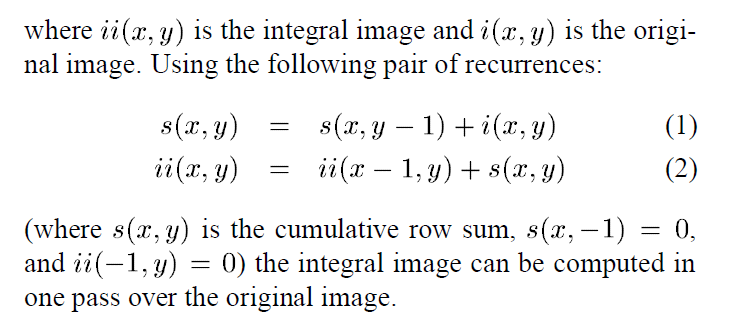

In [127]:
def createIntegralImage(img):
    # 1  2  3  4
    # 5  6  7  8
    # 9  10 11 12
    # 13 14 15 16
    
    
    # S1 S2 S3 S4
    # 1  2  3  4
    # 6  8  10 12
    # 15 18 21 24
    # 28 32 36 40  
    
    # ii 
    # 1  3  6  10
    # 6  14 24 36
    # 15 33 54 78
    # 28 60 96 136
    
    # s(x,y) = s(x,y-1) + img(x,y)
    # 7esbet el row el gdeed
    # ii(x,y) = ii(x-1,y) + s(x,y)
    # Where s(x,y) is the cumulative row sum (y3ny sum el column elly fo2ya bs)
    # s(x, -1) = 0 and ii(-1,y) = 0

    S = np.zeros(img.shape)
    S[0,:] = img[0,:]               # el row el awl
    # Scolumn = np.zeros(img.shape[1])   # S mo5tlfa le kol column
    for i in range(1, img.shape[0]):
        # Scolumn += img[i,:]          # kda kol element fl S hyb2a sum el column elly fo2o + el element nafso
        # S[i,:] = Scolumn             # kda kol row fl S hyb2a sum el column elly fo2o + el row el fo2ya
        S[i,:] = S[i-1,:] + img[i,:] # kda kol row fl S hyb2a sum el column elly fo2o + el row el fo2ya

    ii = np.zeros(img.shape)
    ii[:,0] = S[:,0]                # el column el awl
    for i in range(1, img.shape[1]):
        ii[:,i] = ii[:,i-1] + S[:,i]
    return ii
        


In [128]:
# # make a 2D matrix from 1 to 16, 4x4
# img = np.arange(1,17).reshape(4,4)
# print(img)
# ii = createIntegralImage(img)
# print(ii)
# # 1  3  6  10
# # 6  14 24 36
# # 15 33 54 78
# # 28 60 96 136


In [129]:
class Rectangle:
    def __init__(self, x, y, width, height):
        self.x = x
        self.y = y
        self.width = width
        self.height = height

    def computeRegion(self, integralImage, scale=1.0):
        # A B
        # C D
        # We want to calculate the sum of the pixels in rectangle D
        # Sum = D - C - B + A

        x1 = int(self.x * scale)
        y1 = int(self.y * scale)
        x2 = int((self.x + self.width) * scale) - 1
        y2 = int((self.y + self.height) * scale) - 1

        sumRectD = integralImage[x2][y2]   # Add rectangle D
        if x1 > 0:      # Remove rectangle C
            sumRectD -= integralImage[x1 - 1][y2]
        if y1 > 0:      # Remove rectangle B
            sumRectD -= integralImage[x2][y1 - 1]
        if x1 > 0 and y1 > 0:   # Add rectangle A
            sumRectD += integralImage[x1 - 1][y1 - 1]
        
        return sumRectD

# Haar Features Calculations

In [130]:
class HaarFeature:
    def __init__(self, white, black):
        # Black minus White
        self.white = white
        self.black = black

    def computeFeature(self, integralImage, scale=1.0):
        # Black box minus white box
        whiteSum = np.sum([rectangle.computeRegion(integralImage, scale) for rectangle in self.white])
        blackSum = np.sum([rectangle.computeRegion(integralImage, scale) for rectangle in self.black])
        return blackSum - whiteSum

# Weak Classifier

In [131]:
class WeakClassifier:
    def __init__(self, haarFeature = None, threshold = None, polarity = None):
        self.haarFeature = haarFeature
        self.threshold = threshold
        self.polarity = polarity

    def classify(self, integralImage, scale=1.0):
        # Classifies image based on its integral image
        featureValue = self.haarFeature.computeFeature(integralImage, scale)
        return self.polarity * featureValue < self.polarity * self.threshold * (scale ** 2)
    
    def classifyFeature(self, featureValue):
        return self.polarity * featureValue < self.polarity * self.threshold
    
    def train(self, X, y, weights, positiveWeights = None, negativeWeights = None):
        # if weights aren't given, compute them
        if positiveWeights is None:
            positiveWeights = np.sum(weights[y == 1])
        if negativeWeights is None:
            negativeWeights = np.sum(weights[y == 0])

        # Sort features 
        sortedFeatures = sorted(zip(weights, X, y), key=lambda x: x[1])
        # If weights = [w1, w2, w3], X = [x1, x2, x3], and y = [y1, y2, y3], 
        # then zip(weights, X, y) would produce [(w1, x1, y1), (w2, x2, y2), (w3, x3, y3)]
        # key=lambda x: x[1] means sort by the second element in each tuple, i.e. sort by X

        positiveCounter = 0
        negativeCounter = 0
        sumPositiveWeights = 0
        sumNegativeWeights = 0

        minError = float('inf')
        

        for weight, feature, label in sortedFeatures:
            error = min(sumNegativeWeights + positiveWeights - sumPositiveWeights, 
                        sumPositiveWeights + negativeWeights - sumNegativeWeights)
            
            if error < minError:
                minError = error
                self.threshold = feature
                # bestPolarity = 1 if positiveCounter > negativeCounter else -1
                self.polarity = (positiveCounter > negativeCounter) + (positiveCounter < negativeCounter) * -1
                
            # Update counters
            if label == 1:
                positiveCounter += 1
                sumPositiveWeights += weight
            else:
                negativeCounter += 1
                sumNegativeWeights += weight

# Adaboost

In [132]:
class AdaBoost:
    def __init__(self, nEstimators=50):
        self.nEstimators = nEstimators        # zy number of features kda
        self.alphas = []
        self.classifiers = []                 # list of classifiers
    
    def train(self, X, y, features, lol):
        # X: number of samples
        # y: Labels (0 for -ve, 1 for +ve)
        # features: list of features
        posNum = np.sum(y)
        negNum = len(y) - posNum
        
        # Initialize weights
        weights = np.ones(len(y))
        weights[y == 1] = 1 / (2 * posNum)
        weights[y == 0] = 1 / (2 * negNum)

        # Train classifiers
        for t in range(self.nEstimators):
            print(f"Training {t+1} classifier out of {self.nEstimators} classifiers")

            # Normalize weights
            weights /= np.sum(weights)      # Check if sum of weights is not 0

            weakClassifier = self.trainEstimators(X, y, weights, features)

            classifier, error, incorrectness = self.selectBestClassifier(weakClassifier, X, y, weights)

            if error <= 0.5:
                # Update weights
                beta = error / (1 - error)
                alpha = math.log(1 / (beta + (beta == 0) * 1e-15))      # Check if beta is 0, add 1e-15 to avoid division by 0
                self.alphas.append(alpha)

                
                weights *= np.power(beta, 1-incorrectness)

                self.classifiers.append(classifier)
            else:
                print("Error is greater than 0.5, stopping training")
                break

    def trainEstimators(self, X, y, weights, features):
        # Finding optimal threshold
        weakClassifiers = []
        totalPosWeights = np.sum(weights[y == 1])
        totalNegWeights = np.sum(weights[y == 0])
        
        bar = Bar('Training weak classifiers', max=len(X), suffix='%(percent)d%% - %(elapsed_td)s - %(eta_td)s')
        for i in bar.iter(range(len(X))):
            classifier = WeakClassifier(haarFeature=features[i])
            classifier.train(X[i], y, weights, totalPosWeights, totalNegWeights)
            weakClassifiers.append(classifier)
        
        bar.finish()
        return weakClassifiers
    
    def selectBestClassifier(self, weakClassifiers, X, y, weights):
        bestClassifier = None
        minError = float('inf')
        bestAccuracy = None
        bar = Bar('Selecting best weak classifier', max=len(weakClassifiers), suffix='%(percent)d%% - %(elapsed_td)s - %(eta_td)s')
        i=0
        for classifier in bar.iter(weakClassifiers):
            incorrectness = np.abs(classifier.classify(X) - y)
            error = float(np.sum(np.multiply(incorrectness, weights))) / len(incorrectness)  # Mean error
            
            if error < minError:
                minError = error
                bestClassifier = classifier
                bestAccuracy = incorrectness

            i+=1
        bar.finish()
        return bestClassifier, minError, bestAccuracy
    
    def classify(self, X, scale=1.0):
        total = sum(list(map(lambda x: x[0] * x[1].classify(X, scale), zip(self.alphas, self.classifiers))))
        return total >= 0.5 * sum(self.alphas)
        



# Viola Jones

In [133]:
class ViolaJones:
    def __init__(self, layers, featuresPath = None):
        self.layers = layers
        self.classifiers = []
        self.baseWidth = 24
        self.baseHeight = 24
        self.baseScale = 1
        self.shift = 2
        self.featuresPath = featuresPath

    def train(self, X, y):
        posNum = np.sum(y)
        negNum = len(y) - posNum
        imgHeight, imgWidth = X[0].shape        # All images must be same size

        # Split data into positive and negative
        posIndices = np.where(y == 1)[0]
        negIndices = np.where(y == 0)[0]

        XIntergralImages = np.array(list(map(lambda x: createIntegralImage(x), X)), dtype=np.uint32)
        features = buildFeatures(imgWidth, imgHeight)

        XFeatures = self.loadFeatureDataset()
        if XFeatures is None:
            XFeatures = applyFeatures(XIntergralImages, features)

            if self.featuresPath is not None:
                np.save(self.featuresPath + "xf.npy", XFeatures)
        

        for i, t in enumerate(self.layers):
            if len(negIndices) == 0:
                break

            trainingIndices = np.concatenate((posIndices, negIndices))
            np.random.shuffle(trainingIndices)

            clf = AdaBoost(nEstimators=t)
            clf.train(XFeatures[:, trainingIndices], y[trainingIndices], features, XIntergralImages[trainingIndices])
            self.classifiers.append(clf)

            falsePositives = []
            for negativeIndex in negIndices:
                if clf.classify(XFeatures[negativeIndex]) == 1:
                    falsePositives.append(negativeIndex)
            negIndices = np.array(falsePositives)

    def classify(self, image, scale=1.0):
        return self.classifyIntegralImage(createIntegralImage(image), scale)

    def classifyIntegralImage(self, img, scale = 1):
        for clf in self.classifiers:
            if clf.classify(img, scale) == 0:
                return 0
        return 1
    
    def findFaces(self, pilImage):
        w, h, s = (self.baseWidth, self.baseHeight, self.baseScale)
        regions = []

        pilImage = pilImage.convert('L')
        image = np.array(pilImage)
        imgHeight, imgWidth = image.shape

        integralImage = createIntegralImage(image)

        counter = 0
        while int(w*s) < imgWidth and int(h*s) < imgHeight:
            for y1 in np.arange(0, int(imgHeight - h*s), self.shift):
                for x1 in np.arange(0, int(imgWidth - w*s), self.shift):
                    x1, y1 = int(x1), int(y1)
                    x2, y2 = int(x1 + w*s), int(y1 + h*s)
                    croppedImage = integralImage[y1:y2, x1:x2]

                    if self.classifyIntegralImage(croppedImage, s):
                        regions.append((x1, y1, x2, y2))
                    counter += 1
            w *= s
            h *= s
        return regions
    
    def save(self, filename):
        with open(filename + ".pkl", 'wb') as f:
            pickle.dump(self, f)

    @staticmethod
    def load(filename):
        with open(filename, 'rb') as f:
            return pickle.load(f)
        
    def loadFeatureDataset(self):
        X_f = None
        # Load precomputed features
        try:
            if self.featuresPath:
                X_f = np.load(self.featuresPath + "xf.npy")
                # print("Precomputed dataset loaded!")
        except FileNotFoundError:
            pass
        return X_f


In [134]:
import random

import matplotlib.pyplot as plt
import matplotlib.animation as animation

from nms import nms

def checkData(X, y, num2show=10):
    for i in range(num2show):
        idx = random.randint(0, len(y))
        img = X[idx]
        target = "Face" if y[idx] == 1 else "No face"
        img_text = "Index: {}  -  Target: {}  -  Image size: {}x{}".format(idx, target, *img.shape)
        print(img_text)

        plt.title(img_text)
        plt.imshow(img, cmap='gray')
        plt.show()

def dataAugmentation(X, y):
    facesIndices = np.where(y == 1)[0]
    nonFacesIndices = np.where(y == 0)[0]

    # Horizontal flip (Vertical mirror)
    X_flipped = X[facesIndices, :, ::-1]

    X = np.concatenate((X[facesIndices], X_flipped, X[nonFacesIndices]))
    y = np.zeros(len(X))
    y[:len(facesIndices)*2] = 1

    return X, y

def train():
    # Load data
    Face_size = 400
    test_size = 100
    X = []
    y = []
    i = 0
    for photo in os.listdir("Dataset/Faces/"):
        img = Image.open("Dataset/Faces/"+photo).convert('L')
        # convert L means to make it gray (might be redundant)
        X.append(np.array(img))
        y.append(1)
        i+=1
        if i == Face_size:
            break
    
    for photo in os.listdir("Dataset/NonFaces/"):
        img = Image.open("Dataset/NonFaces/"+photo).convert('L')
        # convert L means to make it gray (might be redundant)
        X.append(np.array(img))
        y.append(0)

    X = np.array(X)
    y = np.array(y)

    X, y = unisonShuffledCopies(X, y)

    clf = ViolaJones(layers=[1, 10, 50, 100], featuresPath="Dataset/Weights/")
    clf.train(X, y)
    clf.save("Dataset/Weights/vj")
    return clf

def test(clf):
    test_size = 100
    X = []
    y = []
    i = 0
    for photo in os.listdir("Dataset/Faces/"):
        img = Image.open("Dataset/Faces/"+photo).convert('L')
        # convert L means to make it gray (might be redundant)
        X.append(np.array(img))
        y.append(1)
        i+=1
        if i == test_size//2:
            break
    
    i = 0
    for photo in os.listdir("Dataset/NonFaces/"):
        img = Image.open("Dataset/NonFaces/"+photo).convert('L')
        # convert L means to make it gray (might be redundant)
        X.append(np.array(img))
        y.append(0)
        i+=1
        if i == test_size//2:
            break

    X = np.array(X)
    y = np.array(y)

    metrics = evaluate(clf, X, y, show_samples=False)
    counter = 0
    for k, v in metrics.items():
        counter += 1
        if counter <= 4:
            print("\t- {}: {:,}".format(k, v))
        else:
            print("\t- {}: {:.3f}".format(k, v))

def trainTest():
    clf = train()
    test(clf)

def findFaces():
    clf = ViolaJones.load("Dataset/Weights/vj.pkl")
    
    pil_img = Image.open("Dataset/Testing/Faces/10587.jpg")
    regions = clf.findFaces(pil_img)

    scores = [1.0]*len(regions)  #np.ones(len(regions))
    indicies = nms.boxes(regions, scores)
    regions = np.array(regions)
    drawn_img = draw_bounding_boxes(pil_img, list(regions[indicies]), thickness=1)
    plt.imshow(drawn_img)
    plt.show()

def drawFeatures():
    testName = 100
    MAXFACES = 1
    frames = []
    Face_size = 400
    fig = plt.figure()

    X = []
    y = []
    i = 0
    for photo in os.listdir("Dataset/Faces/"):
        img = Image.open("Dataset/Faces/"+photo).convert('L')
        # convert L means to make it gray (might be redundant)
        X.append(np.array(img))
        y.append(1)
        i+=1
        if i == Face_size:
            break
    
    for photo in os.listdir("Dataset/NonFaces/"):
        img = Image.open("Dataset/NonFaces/"+photo).convert('L')
        # convert L means to make it gray (might be redundant)
        X.append(np.array(img))
        y.append(0)

    X = np.array(X)
    y = np.array(y)

    XFaces = X[y == 1]
    clf = ViolaJones.load("Dataset/Weights/vj.pkl")

    for i, np_img in enumerate(XFaces):
        if i < MAXFACES:
            # For each Adaboost in the Cascade
            for ab in clf.clfs:

                # For each Weak learner
                for wc in ab.clfs:
                    print("New frame: {}".format(len(frames)))

                    drawn_img = draw_haar_feature(np_img,  wc.haar_feature)
                    img = plt.imshow(drawn_img, cmap="gray")
                    frames.append([img])
                    #plt.savefig(video_folder + "/file_%d.png" % i)
                    #plt.show()
    ani = animation.ArtistAnimation(fig, frames, interval=100, blit=True,
                                    repeat_delay=1000)
    ani.save("Dataset/Testing2/{}/video_{}".format(testName, testName) + '.mp4', writer='ffmpeg')
    plt.show()


In [135]:
trainTest()
# drawFeatures()

Training 1 classifier out of 1 classifiers


C:\Users\DELL\AppData\Local\Temp\ipykernel_26376\1821960213.py:11: RuntimeWarning: overflow encountered in scalar subtract
  return blackSum - whiteSum


IndexError: invalid index to scalar variable.

# 2a5er 7aga isA

In [ ]:
# class ViolaJonesDetector:
#     def __init__(self):
#         print("Loading Viola Jones classifiers...")
#         classifiers = load_classifiers(classifiersFileName)
#         print(f'{len(classifiers)} classifiers loaded.')
#         self.classifiersStages = classifierStages(classifiers)
        
#     def detect(self, frame):
#         integralImage = createIntegralImage(frame)
#         frameWidth = frame.shape[1]
#         frameHeight = frame.shape[0]
#         rectangles = detectFaces(integralImage, frameWidth, frameHeight, self.classifiersStages)
#         print(f"There are {len(rectangles)} Non suppressed rects")
#         rectangles = nonMaximumSuppression(rectangles)
#         print(f"There are now {len(rectangles)} suppressed rects")
#         return rectangles
    


        


# Sadge